# Single Rectangle Detection

## Import Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

## Data Generation

In [2]:
# Create images with random rectangles and bounding boxes. 
num_imgs = 50000

img_size = 8
min_object_size = 1
max_object_size = 4
num_objects = 1

# create and zero two arrays, one is for the bounding boxes, the other is for the images
bboxes = np.zeros((num_imgs, num_objects, 4))
# set the pixel value of the background to 0
imgs = np.zeros((num_imgs, img_size, img_size))

for i_img in range(num_imgs):
    for i_object in range(num_objects):
        # set the width and height of the rectangle
        w, h = np.random.randint(min_object_size, max_object_size, size = 2)
        # set the location (x, y) of the rectangle
        x = np.random.randint(0, img_size - w)
        y = np.random.randint(0, img_size - h)
        # set the pixel value of the rectangle to 1
        imgs[i_img, x:x + w, y:y + h] = 1.0
        bboxes[i_img, i_object] = [x, y, w, h]
        
print("Image Shape: {}".format(imgs.shape))
print("Bounding Box Shape: {}".format(bboxes.shape))

Image Shape: (50000, 8, 8)
Bounding Box Shape: (50000, 1, 4)


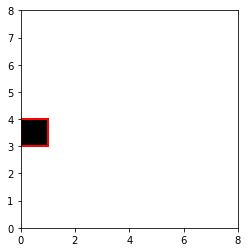

In [3]:
i = 0
# origin: place the [0, 0] index of the array in the upper left or lower left corner of the axes
# extent: floats(left, right, bottom, top)
plt.imshow(imgs[i].T, cmap = 'Greys', interpolation = 'none', origin = 'lower', extent = [0, img_size, 0, img_size])
# tranverse(.T) and flip upside down(origin = 'lower') to fit in the bounding box
for bbox in bboxes[i]:
    plt.gca().add_patch(matplotlib.patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], lw = 2, ec = 'r', fc = 'none'))
    # patches.Rectangle((x, y), w, h, linewidth, edgecolor, facecolor)

## Preprocessing

In [4]:
# Reshape and normalize the image data to mean 0 and std 1. 
X = (imgs.reshape(num_imgs, -1) - np.mean(imgs)) / np.std(imgs)
X.shape, np.mean(X), np.std(X)

((50000, 64), 3.368416656712725e-18, 1.0)

In [5]:
# Normalize x, y, w, h by img_size, so that all values are between 0 and 1.
# Important: Do not shift to negative values (e.g. by setting to mean 0), because the IOU calculation needs positive w and h.
y = bboxes.reshape(num_imgs, -1) / img_size
y.shape, np.mean(y), np.std(y)

((50000, 4), 0.281453125, 0.17495891747131487)

## Train Test Split

In [6]:
# Split training and test.
i = int(0.8 * num_imgs)
train_X, test_X = X[:i], X[i:]
train_y ,test_y = y[:i], y[i:]
test_imgs = imgs[i:]
test_bboxes = bboxes[i:]

## Model

In [8]:
# Build the model.
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.callbacks import ModelCheckpoint
model = Sequential([
        Dense(200, input_dim = X.shape[-1]),
        Activation('relu'), 
        Dropout(0.2), 
        Dense(y.shape[-1])
        ])
model.compile(loss = 'mse', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 200)               13000     
_________________________________________________________________
activation_1 (Activation)    (None, 200)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 804       
Total params: 13,804
Trainable params: 13,804
Non-trainable params: 0
_________________________________________________________________


## Training

In [19]:
# Train
model.fit(train_X, train_y, epochs = 30, validation_data = (test_X, test_y), verbose = 1,
          callbacks = [ModelCheckpoint('Single_Rectangle_model.h5',
                                       monitor = 'val_accuracy',
                                       save_best_only = True)])

Epoch 1/30
1250/1250 [==============================] - 1s 883us/step - loss: 0.0260 - accuracy: 0.7088 - val_loss: 7.8385e-04 - val_accuracy: 0.8944
Epoch 2/30
1250/1250 [==============================] - 1s 783us/step - loss: 0.0023 - accuracy: 0.8438 - val_loss: 2.9428e-04 - val_accuracy: 0.8753
Epoch 3/30
1250/1250 [==============================] - 1s 787us/step - loss: 0.0014 - accuracy: 0.8486 - val_loss: 1.6840e-04 - val_accuracy: 0.8721
Epoch 4/30
1250/1250 [==============================] - 1s 781us/step - loss: 0.0011 - accuracy: 0.8478 - val_loss: 1.6911e-04 - val_accuracy: 0.8322
Epoch 5/30
1250/1250 [==============================] - 1s 785us/step - loss: 9.4217e-04 - accuracy: 0.8485 - val_loss: 2.1356e-04 - val_accuracy: 0.8855
Epoch 6/30
1250/1250 [==============================] - 1s 796us/step - loss: 8.4843e-04 - accuracy: 0.8477 - val_loss: 1.7260e-04 - val_accuracy: 0.8604
Epoch 7/30
1250/1250 [==============================] - 1s 850us/step - loss: 7.9675e-04 - a

## Prediction

In [20]:
# Predict bounding boxes on the test images.
from keras.models import load_model
model_test = load_model('Single_Rectangle_model.h5')
prediction = model_test.predict(test_X)
pred_bboxes = prediction * img_size
pred_bboxes = pred_bboxes.reshape(len(pred_bboxes), num_objects, -1)
pred_bboxes.shape

(10000, 1, 4)

## IoU Calculating Function

In [21]:
def IOU(bbox1, bbox2):
    '''Calculate overlap between two bounding boxes [x, y, w, h] as the area of intersection over the area of unity'''
    x1, y1, w1, h1 = bbox1[0], bbox1[1], bbox1[2], bbox1[3]
    x2, y2, w2, h2 = bbox2[0], bbox2[1], bbox2[2], bbox2[3]

    w_I = min(x1 + w1, x2 + w2) - max(x1, x2)
    h_I = min(y1 + h1, y2 + h2) - max(y1, y2)
    if w_I <= 0 or h_I <= 0:  # no overlap
        return 0.
    I = w_I * h_I

    U = w1 * h1 + w2 * h2 - I

    return I / U

## Visualize Results

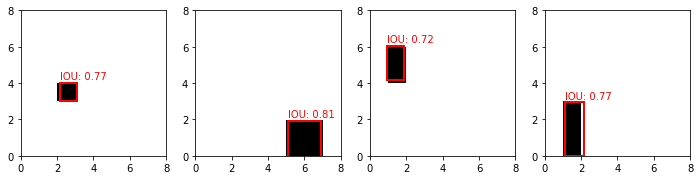

In [24]:
# Show a few images and predicted bounding boxes from the test dataset. 
plt.figure(figsize = (12, 3))
for i_subplot in range(1, 5):
    plt.subplot(1, 4, i_subplot)
    i = np.random.randint(len(test_imgs))
    plt.imshow(test_imgs[i].T, cmap = 'Greys', interpolation = 'none', origin = 'lower', extent = [0, img_size, 0, img_size])
    for pred_bbox, exp_bbox in zip(pred_bboxes[i], test_bboxes[i]):
        plt.gca().add_patch(matplotlib.patches.Rectangle((pred_bbox[0], pred_bbox[1]), pred_bbox[2], pred_bbox[3], lw = 2, ec = 'r', fc = 'none'))
        plt.annotate("IOU: {:.2f}".format(IOU(pred_bbox, exp_bbox)), (pred_bbox[0], pred_bbox[1] + pred_bbox[3] + 0.2), color = 'r')
        # plt.annotate(text, (x, y), color)
        
plt.savefig("single-rectangle_prediction.png", dpi = 100)

## Overall Assessment

In [25]:
# Calculate the mean IOU (overlap) between the predicted and expected bounding boxes on the test dataset. 
summed_IOU = 0.
for pred_bbox, test_bbox in zip(pred_bboxes.reshape(-1, 4), test_bboxes.reshape(-1, 4)):
    summed_IOU += IOU(pred_bbox, test_bbox)
mean_IOU = summed_IOU / len(pred_bboxes)
mean_IOU

0.8310774643257784